<font size="20"> Проект Телеком</font>

# Введение

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<b>Цель:</b> Построить модель способную прогнозировать уход клиента от оператора связи.

## Импорты

In [1]:
import pandas as pd
import warnings
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

warnings.filterwarnings('ignore')

RND = 80523

Установка необходимых компанентов

In [2]:
try:
    import pandas_profiling
    from pandas_profiling import ProfileReport
except:
    !pip install -U pandas-profiling
    import pandas_profiling
    from pandas_profiling import ProfileReport
try:
    from sklearn.datasets import make_classification
    from lightgbm import LGBMClassifier
except:
    !pip3 install lightgbm
    from sklearn.datasets import make_classification
    from lightgbm import LGBMClassifier

# Знакомство с данными

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

In [3]:
try:
    contract = pd.read_csv('contract_new.csv')
    internet = pd.read_csv('internet_new.csv')
    personal = pd.read_csv('personal_new.csv')
    phone = pd.read_csv('phone_new.csv')
except: 
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

**Беглый взгляд на данные**

Посмотрим на каждый из загруженных файлов информацию о нем и наличие пропусков

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [8]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [11]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

Во всех таблицах отсутствуют пропуски. Наш целевой признак EndDate из таблицы contract.

In [17]:
contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [18]:
tables = ['contract', 'internet', 'personal', 'phone']

In [19]:
for t in tables:
    print(f'Количество записей в таблице {t} -', globals()[t].shape)

Количество записей в таблице contract - (7043, 8)
Количество записей в таблице internet - (5517, 8)
Количество записей в таблице personal - (7043, 5)
Количество записей в таблице phone - (6361, 2)


## Выводы по первоначальным файлам с данными

Рассмотрены датафреймы:

- `contract` — информация о договоре;
- `personal` — персональные данные клиента;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.

Во всех датафреймах отсутствуют пропуски. <br>
При беглом взгляде анамалии видны только в признаках `MonthlyCharges` и `TotalCharges` из датафрейма с информацией о договоре. Испралять это не следует, т.к. эти призначи содержат даные об оплате и естественно, что оплата будет разной в зависимости от подключенных услуг.<br>
`contract` и `personal` содержат по 7043 записи, а `internet` 5517, `phone` 6361. <br>
Это тоже не выглядит, как аномалия так, как не все клиенты подключены к интернету и телефонии. Следовательно они отсутствуют в этих таблицах. <br>
Однако, для дальнейшей работы потребуется объединять все датафреймы в одну плоскую таблицу и в ней возникнут пропуски.


## План работ

* Исследовательский анализ
    * на этом этапе предпологается объединение всех таблиц в единый датафрейм.
    * анализ получившегося датафрейма
* Предобработка данных
    * замена целевого признака `EndDate` на бинарный
    * обработка пропущеных значений
    * поиск анамалий
    * удаление не влияющих на обучение признаков
    * создание новых признаков
* Разделение на выборки
    * разделение на тестовую и тренировачную выборки
* Кодирование
* Обучение моделей
    * обучение нескольких моделей на тренировочной выборке
    * определение наилучшей модели
* Проверка лучшей модели на тестовой выборке
* Общий вывод

# Исследовательский анализ

Объединение в единый фрейм по ключу `customerID`.<br>
`customerID` сделан индексным, так как не нужен при дальнейшем обучении моделей.

In [4]:
df = contract.merge(internet, on='customerID', how='left')
df = df.merge(personal, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')
df = df.set_index('customerID')

In [21]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


**Отчет по полоученному датафрейму**

In [5]:
profile = ProfileReport(df, title="Отток клиентов у оператора связи")

In [23]:
profile.to_file(output_file="telecom.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**profile автоматически создает супер отчет по всем полям со всеми мыслемыми граффиками, возможностью сохранения в pdf например или отображением во фрейме. Вот скриншот.**

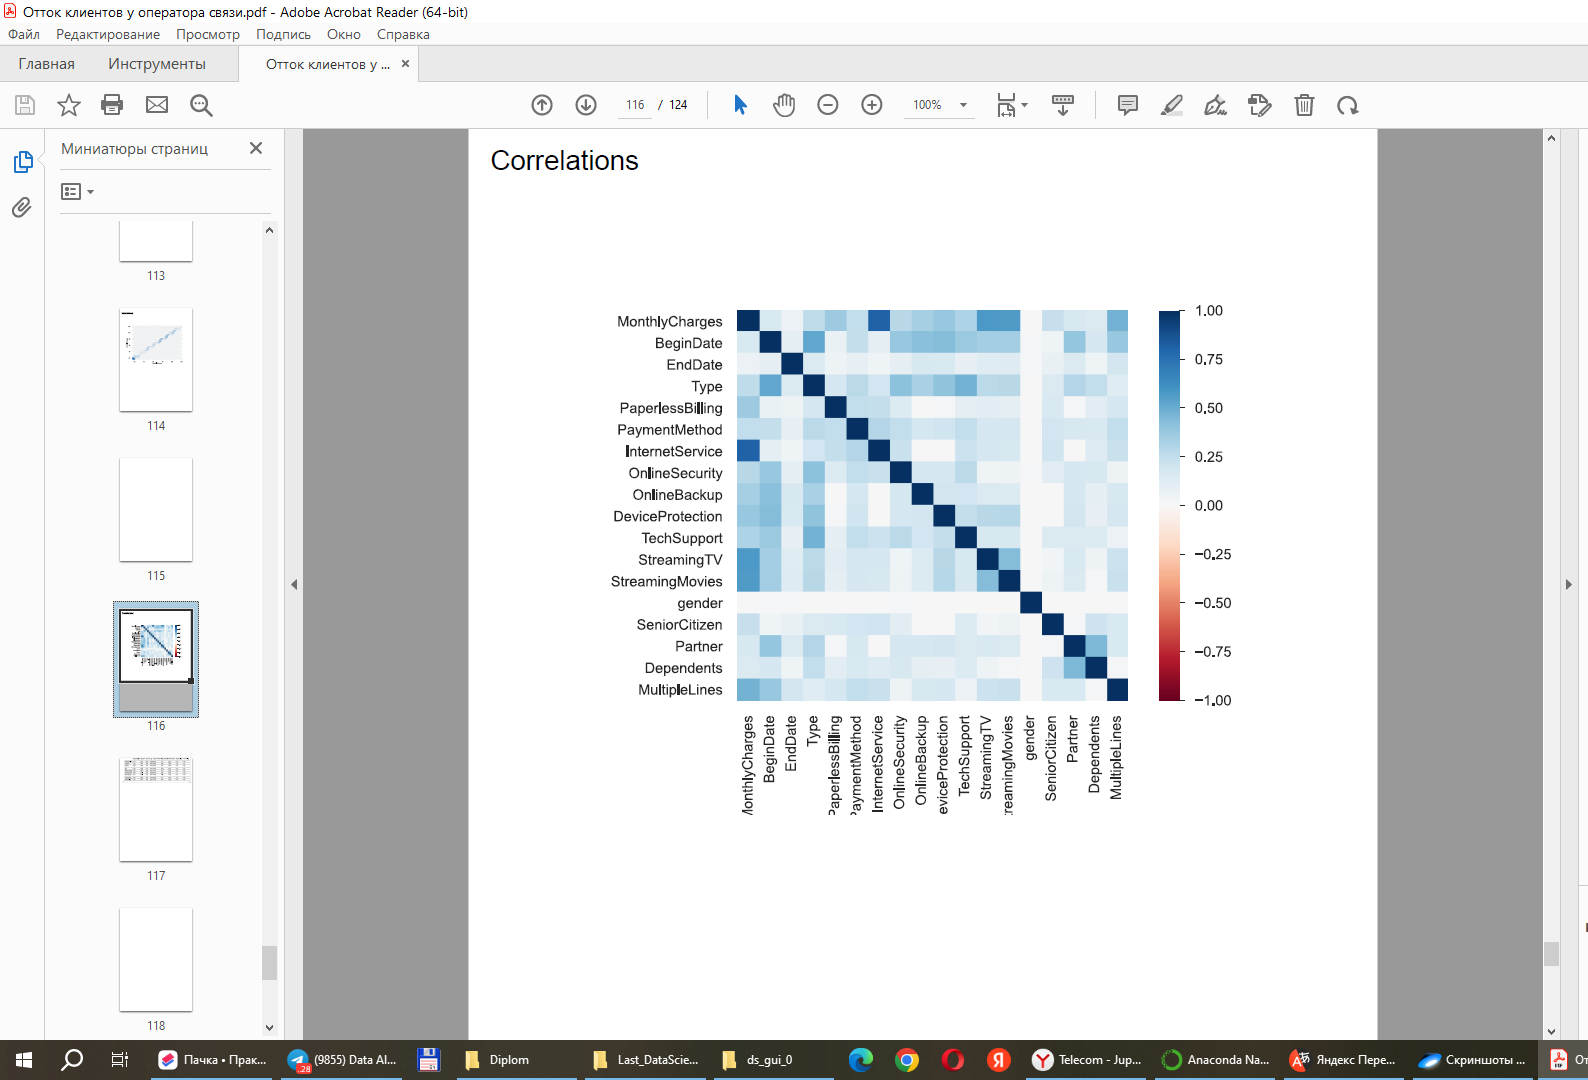

## Выводы

* Явной корреляции между признаками нет.
* В некоторых столбцах есть пропущенные значения. Это нормальное явление. Например в случае если клиент не подключал интернет сервисы то у него там пусто.
* Необходимо привести все категориальные столбцы к нижнему реестру
* Для признака `TotalCharges` изменить тип данных с object на float
* Добавить признак с числом дней, которые клиент находился в компании. Для этого `BeginDate` и `EndDate` привести к типу datetime
* Заменить значения в `EndDate` на 1 если дата существует и 0, если ее нет
* Удалить 'BeginDate'. Так как нам не важно какогда пришел клиент, а важно сколько он оставался клиентом.


# Предобработка данных

## Приведем все категориальные столбцы к нижнему реестру

In [25]:
for column in ['EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 
              'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 
               'Partner', 'Dependents', 'MultipleLines']:
    df[column] = df[column].str.lower()

In [26]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04,dsl,no,yes,no,no,no,no,female,0,yes,no,NaN
5575-GNVDE,2017-04-01,no,one year,no,mailed check,56.95,2071.84,dsl,yes,no,yes,no,no,no,male,0,no,no,no
3668-QPYBK,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17,dsl,yes,yes,no,no,no,no,male,0,no,no,no
7795-CFOCW,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1960.6,dsl,yes,no,yes,yes,no,no,male,0,no,no,NaN
9237-HQITU,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.5,fiber optic,no,no,no,no,no,no,female,0,no,no,no


## Замена типов данных и создание новых признаков

Меняем тип данных `TotalCharges`

In [27]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Добавим признак для `EndDate` для, которого 1 - факт ухода клиента - значение 'no' в `EndDate` и 0 -любая другая дата.

In [28]:
df['end'] = 0
df.loc[df['EndDate'] < '2020-02-01', 'end'] = 1

In [29]:
df.loc[:, ['EndDate', 'end']].sample(5)

,EndDate,end
customerID,,
5829-NVSQN,no,0
0228-MAUWC,no,0
1894-IGFSG,2019-12-01,1
3170-GWYKC,no,0
1768-HNVGJ,2019-12-01,1


Для расчета, колличества дней, которые клиент был в компании понадобиться:<br>
Значения `no` в `EndDate` заменить датой выгрузки данных - 1 февраля 2020
Преобразовать типы данных `EndDate` и `BeginDate`.

In [30]:
df.loc[df['EndDate'] == 'no', 'EndDate'] = '2020-02-01'

In [31]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

In [32]:
df.loc[:, ['EndDate', 'BeginDate']].sample(5)

,EndDate,BeginDate
customerID,,
8859-YSTWS,2020-02-01,2016-02-01
3692-JHONH,2020-02-01,2015-10-01
2007-QVGAW,2018-12-01,2014-06-01
7162-WPHPM,2020-02-01,2015-04-01
6993-YCOBK,2020-02-01,2015-02-01


Ставим новый признак показывающий количество дней, которые клиент был в компании.

In [33]:
df['day_sum'] = (df['EndDate'] - df['BeginDate']) // np.timedelta64(1, 'D')

In [34]:
df.loc[:, ['EndDate', 'BeginDate', 'day_sum']].sample(5)

,EndDate,BeginDate,day_sum
customerID,,,
1208-DNHLN,2020-02-01,2017-12-01,792
0362-ZBZWJ,2020-01-01,2017-01-01,1095
8950-MTZNV,2020-02-01,2020-01-01,31
4367-NUYAO,2020-02-01,2020-02-01,0
1839-FBNFR,2020-02-01,2016-11-01,1187


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   InternetService   5517 non-null   object        
 8   OnlineSecurity    5517 non-null   object        
 9   OnlineBackup      5517 non-null   object        
 10  DeviceProtection  5517 non-null   object        
 11  TechSupport       5517 non-null   object        
 12  StreamingTV       5517 non-null   object        
 13  StreamingMovies   5517 non-null   object        
 14  gender        

## Обработка пропущеных значений

In [36]:
df.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
end                    0
day_sum                0
dtype: int64

Получилось 11 пропущенных значений `TotalCharges`<br>
В полях `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` по 1526 пропусков.<br>
В `MultipleLines` - 682

В `TotalCharges` 11 пропущеных значений и все они приходятся на дату выгрузки данных. <br>
Этот признак показывает расходы клиента, но у него на эту дату приходиться дата заключения договора. <br>
Можно предположить, что значения этого поля равны начальному платежу `MonthlyCharges`, но по факту расходов то есть списаний еще не было.<br>
Вот юридически нужно ноль постакить.

In [37]:
df[df['TotalCharges'].isnull()] 

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,end,day_sum
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,two year,yes,bank transfer (automatic),52.55,NaN,dsl,yes,no,...,yes,yes,no,female,0,yes,yes,NaN,0,0
3115-CZMZD,2020-02-01,2020-02-01,two year,no,mailed check,20.25,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,male,0,no,yes,no,0,0
5709-LVOEQ,2020-02-01,2020-02-01,two year,no,mailed check,80.85,NaN,dsl,yes,yes,...,no,yes,yes,female,0,yes,yes,no,0,0
4367-NUYAO,2020-02-01,2020-02-01,two year,no,mailed check,25.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,male,0,yes,yes,yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,two year,no,credit card (automatic),56.05,NaN,dsl,yes,yes,...,yes,yes,no,female,0,yes,yes,NaN,0,0
7644-OMVMY,2020-02-01,2020-02-01,two year,no,mailed check,19.85,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,male,0,yes,yes,no,0,0
3213-VVOLG,2020-02-01,2020-02-01,two year,no,mailed check,25.35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,male,0,yes,yes,yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,two year,no,mailed check,20.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,female,0,yes,yes,no,0,0
2923-ARZLG,2020-02-01,2020-02-01,one year,yes,mailed check,19.70,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,male,0,yes,yes,no,0,0


In [38]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

1526 пропусков в полях `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`. <br>
Все эти поля категориальые из таблицы `internet` и относятся к пользователям, котоорые просто не подключали дополнительных услуг связанных с интернетом<br>
Для этих пользователей простави 'no'

In [39]:
df[['InternetService', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection',
   'TechSupport', 'StreamingTV', 'StreamingMovies']] = df[['InternetService', 
                                                          'OnlineSecurity', 
                                                           'OnlineBackup', 'DeviceProtection',
                                                          'TechSupport', 'StreamingTV', 
                                                           'StreamingMovies']].fillna('no')

`MultipleLines` - многокональная телефонная линия. Тут, тоже пользователи у которых не подключена эта услуга.<br>
Заполним 'no'

In [40]:
df['MultipleLines'] = df['MultipleLines'].fillna('no')

In [41]:
df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
end                 0
day_sum             0
dtype: int64

Пропуски устранены.

## Удаление не нужных признаков

Признаки `BeginDate` и `EndDate` - не нужны. <br>
От даты подключения скорее всего никак не зависит джата отключения.<br>
Они заменены на целевой признак `end` - флаг ухода пользователя и `day_sum` - количество днекй которые пользователь был в компании.

In [42]:
df=df.drop(['BeginDate', 'EndDate'], axis=1)

In [43]:
df.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'end', 'day_sum'],
      dtype='object')

## Выводы

В результате предобработки даных, значения категориальных признаков приведено к нижнему реестру.<br>
Изменен тип данных для `TotalCharges`<br>
Создан целевой признак `end` на основании данных столбца `EndDate`. <br>
В `end` еденицей обозначен факт ухода клиента.<br>
На основании данных `BeginDate` и `EndDate` создан признак `day_sum`, показывающи число дней, которые пользователь оставался клиентом компаниии.<br>
Была произведена обработка пропущенных значений:
* В `TotalCharges` 11 пропущеных значений и все они приходятся на дату выгрузки данных. Этот признак показывает расходы клиента, но у него на эту дату приходиться дата заключения договора.
* В полях `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` по 1526 пропусков. Эти поля показываль подключение клиентов к интернет услугам. Для клиентов, которые этими услугами не пользовались, при объединеии датасетов возникли пропуски. Пропуски были заменены на 'no'.
* В `MultipleLines` - 682 пропусков. Они оббозначали клиентов не пользующимися услугами многокональной телефонии.

Были удалены ненужные признаки - `BeginDate`, `EndDate`.

Данные подготовлены к разделению на выборки и дальнейшему кодированию.

# Разделение на выборки

Для дальнейшей работы, необходимо разделить данные на тестовую и тренировачную выборки. <br>
Тестовая часть должна занимать 25% от всего объема.

<AxesSubplot:title={'center':'соотношение 75/25'}, ylabel='разделение датафрейма'>

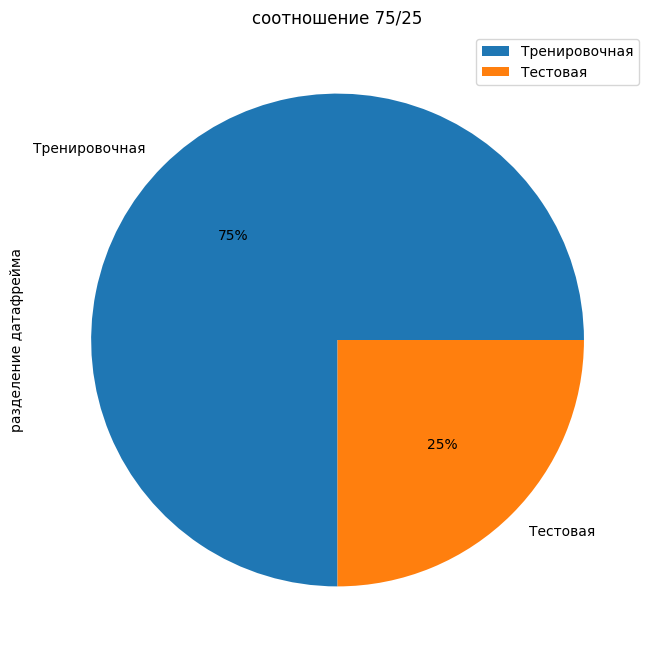

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('end', axis=1), df.end, test_size=0.25, random_state=RND)
data_separation = pd.DataFrame({'name': ['Тренировочная',
                                         'Тестовая'],
                                'разделение датафрейма': [
                                    X_train.shape[0],
                                    X_test.shape[0]]})
data_separation = data_separation.set_index('name')
data_separation.plot(kind='pie', y='разделение датафрейма', autopct='%1.0f%%', title='соотношение 75/25',
                    figsize=(12, 8))

# Кодирование

Для кодирования признаков будем использовать OneHotEncoder

In [45]:
columns = list(df.select_dtypes(include=['object']).columns)
print(columns)

['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'Partner', 'Dependents', 'MultipleLines']


In [46]:
ohe = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore', 
                                             sparse=False), columns), remainder='passthrough')

In [47]:
transformed = ohe.fit_transform(X_train)
X1_train = pd.DataFrame(transformed, columns=ohe.get_feature_names(), index=X_train.index)

In [48]:
transformed = ohe.transform(X_test)
X1_test = pd.DataFrame(transformed, columns=ohe.get_feature_names(), index=X_test.index)

# Обучение моделей

In [49]:
time_fit =[] # это для времени
ROC_AUC_model = [] #  ROC-AUC модели
name_model = [] # название модели

## RandomForestClassifier

In [50]:
%%time
name_model.append('RandomForestClassifier')
start = time.time()

pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state = RND))])

param_grid = {
    'classifier__n_estimators': [10, 50, 100], #, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__n_jobs': [-1],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

rfc_grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')
rfc_grid_search.fit(X1_train, y_train)

time_fit.append(time.time() - start)
ROC_AUC_model.append(rfc_grid_search.best_score_)
print('Лучшие параметры:', rfc_grid_search.best_params_)
print('*'*30)
print('ROC-AUC score:', rfc_grid_search.best_score_)
print('*'*30)

Лучшие параметры: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__n_jobs': -1}
******************************
ROC-AUC score: 0.8252622852336213
******************************
CPU times: total: 31.4 s
Wall time: 33.4 s


## LogisticRegression

In [52]:
%%time
name_model.append('LogisticRegression')
start = time.time()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=RND))
])

lr_param_grid = {
    'logreg__C': [0.1, 1, 2, 5, 10],
    'logreg__class_weight': [None, 'balanced'],
    'logreg__fit_intercept': [True, False],
    'logreg__max_iter': [100, 200, 70],
    'logreg__solver': ['lbfgs', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'logreg__tol': [0.0001, 0.001],
    'logreg__penalty': ['l1', 'l2']
}

lr_grid_search = GridSearchCV(pipe, param_grid=lr_param_grid, cv=5, scoring='roc_auc')

lr_grid_search.fit(X1_train, y_train)

time_fit.append(time.time() - start)
ROC_AUC_model.append(lr_grid_search.best_score_)

print('Лучшие параметры:', lr_grid_search.best_params_)
print('*'*30)
print('ROC-AUC score:', lr_grid_search.best_score_)
print('*'*30)


Лучшие параметры: {'logreg__C': 2, 'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'saga', 'logreg__tol': 0.0001}
******************************
ROC-AUC score: 0.770061882715129
******************************
CPU times: total: 2min 27s
Wall time: 2min 25s


## LGBMClassifier

In [53]:
%%time
name_model.append('LGBMClassifier')
start = time.time()

pipe = Pipeline([("clf", LGBMClassifier(random_state=RND))])

params_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5]
}

lgbm_grid_search = GridSearchCV(
    pipe, params_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)

lgbm_grid_search.fit(X1_train, y_train)

time_fit.append(time.time() - start)
ROC_AUC_model.append(lgbm_grid_search.best_score_)

print('Лучшие параметры:', lgbm_grid_search.best_params_)
print('*'*30)
print('ROC-AUC score:', lgbm_grid_search.best_score_)
print('*'*30)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 300}
******************************
ROC-AUC score: 0.8763759771691738
******************************
CPU times: total: 1.44 s
Wall time: 2.24 s


## Анализ моделей

In [55]:
results = {
    'Model' : pd.Series(name_model),
    'Time fit': pd.Series(time_fit),
    'ROC-AUC' :pd.Series(ROC_AUC_model),
    }
results = pd.DataFrame(results)
results = results.set_index('Model')
results = results.sort_values('ROC-AUC')
display(results)

,Time fit,ROC-AUC
Model,,
LogisticRegression,145.973654,0.770062
RandomForestClassifier,33.378133,0.825262
LGBMClassifier,2.240059,0.876376


<AxesSubplot:xlabel='Model'>

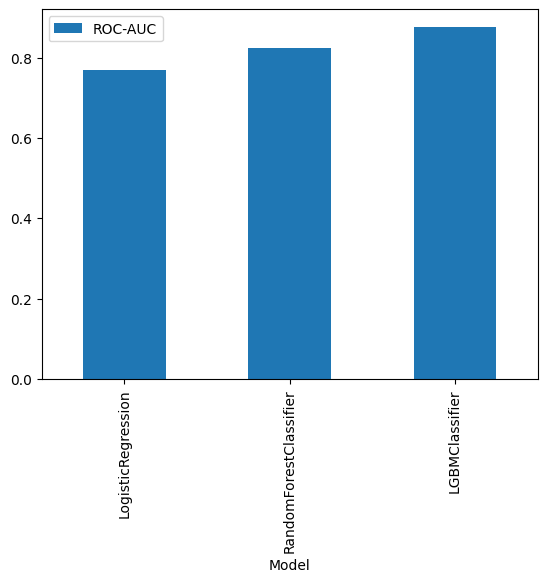

In [56]:
results['ROC-AUC'].plot(kind='bar', legend=True)

## Вывод по обучению на тренировочных данных

Для обучения моделей данные были разделены на обучающую и тестовую выборки.<br>
Предворительное кодирование осуществлялоь с помощью OneHotEncoder.<br>
Для оценки качества использовалась метрика ROC-AUC (Area Under the ROC Curve), т.к. она показывает качество бинарной классификации, то есть способность модели разделять два класса - положительный и отрицательный. 

В процессе обучения использовались:
* RandomForestClassifier
* LogisticRegression
* LGBMClassifier

**RandomForestClassifier**  **ROC-AUC** для этой модели **0.825262**, при времени обучения 23.21.<br>
Лучшиме параметрамы для достижения этого результата - {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__n_jobs': -1}

**LogisticRegression** с параметрами: {'logreg__C': 2, 'logreg__class_weight': None, 'logreg__fit_intercept': True, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'saga', 'logreg__tol': 0.0001} дало значение **ROC-AUC 0.770062**, при времени обучения 98.78.<br>
То есть, это самая медленная модель с самыми плохими показателями.

**LGBMClassifier** сдесь показатели оказались самыми лучшими **ROC-AUC 0.876376** и самое короткое время обучения 1.98. <br>
Лучшие параметры: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 300}<br>
Целью работы было достижение значения на тесте **ROC-AUC >= 85**, таким образом, эта модель лучьше прочих подходит для дальнейшего тетирования.

# Проверка качества лучшей модели и исследование важности признаков

Проверим модель **LGBMClassifier** на тестовых данных.

In [57]:
y_test_pred_proba = lgbm_grid_search.best_estimator_.predict_proba(X1_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print('ROC AUC на тестовых данных:', test_roc_auc)

ROC AUC на тестовых данных: 0.9049379115125492


ROC-кривая для LGBMClassifier будет выглядить так:

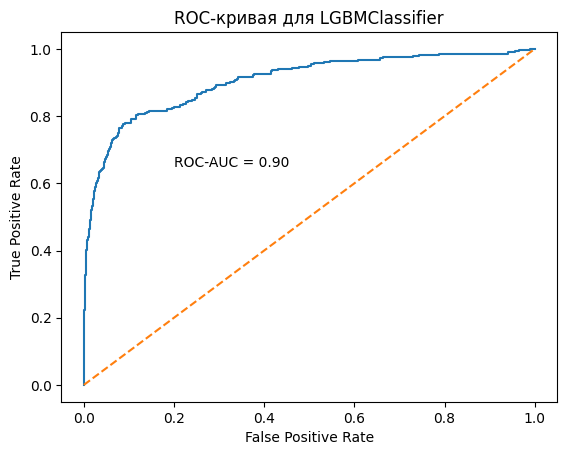

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.text(0.2,0.65,'ROC-AUC = {:.2f}'.format(test_roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для LGBMClassifier')
plt.show()

**Построим матрицу ошибок**, которая показывает, как алгоритм классификации классифицирует каждый объект тестовой выборки на основе его истинного класса.

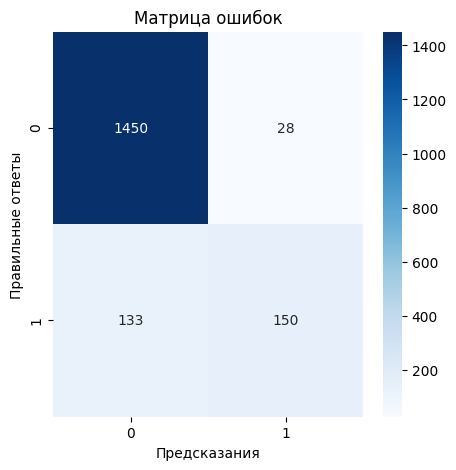

In [59]:
y_test_pred = lgbm_grid_search.best_estimator_.predict(X1_test)
cmatrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cmatrix,
            annot=True,  
            cmap='Blues', 
            fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show();

In [60]:
lgbm_best = lgbm_grid_search.best_estimator_.named_steps['clf']

In [61]:
importance = lgbm_best.feature_importances_
names = X1_train.columns
features = pd.DataFrame({'feature': names, 'importance': importance})
features = features.sort_values(by=['importance'], ascending=False)
print(features)

                                      feature  importance
21                                    day_sum        2003
18                             MonthlyCharges        1135
19                               TotalCharges         937
14                    onehotencoder__x10_male         153
16                     onehotencoder__x12_yes         146
0                  onehotencoder__x0_one year         144
15                     onehotencoder__x11_yes         141
1                  onehotencoder__x0_two year         127
3   onehotencoder__x2_credit card (automatic)         113
10                      onehotencoder__x6_yes         108
11                      onehotencoder__x7_yes          96
17                     onehotencoder__x13_yes          94
8                       onehotencoder__x4_yes          86
13                      onehotencoder__x9_yes          83
2                       onehotencoder__x1_yes          83
12                      onehotencoder__x8_yes          75
9             

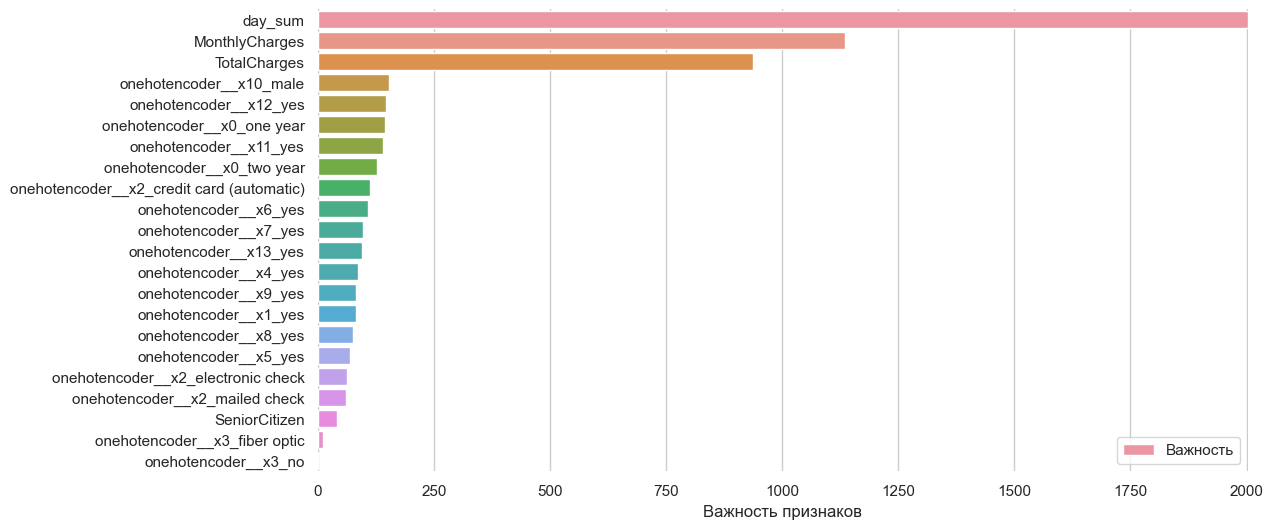

In [62]:
sns.set(style='whitegrid')

f, ax = plt.subplots(figsize=(12, 6))

sns.set_color_codes('muted')
sns.barplot(x='importance', y='feature', data=features,
            label='Важность')#, color='b')

ax.legend(ncol=2, loc='lower right', frameon=True)
ax.set(xlim=(0, max(features['importance'])), ylabel="",
       xlabel='Важность признаков')
sns.despine(left=True, bottom=True)

Время пользования услугами компании, является ключевым фактором. Также большое значение имеют ежемесячные траты. Так же важны признаки отвечающие за гендер и тип оплаты. 

## Выводы по тестированию

Проведено тестирование лучшей модели LGBMClassifier тестоых данных. ROC-AUC для этой модели составило 0.90. Это значение полностью под ходит под цели проекта.<br>
Для этой модели была построина ROC кривая и матрица ошибок.<br>
Можно сказать, что модель почти всегда правильно классифицирует первый класс (общее количество объектов этого класса равно 1450, а число ложных предсказаний составляет всего 28).<br>
Однако, второй класс классифицируется несовершенно (общее число объектов этого класса равно 283, из которых 133 были ошибочно отнесены к первому классу, а 150 правильно классифицированы). <br>
Наиболее значимыми признаками являются время пользование услугами компании и ежемесячные траты.

# Общий вывод

Оператору связи «Ниединогоразрыва.ком» требовалось получить модель способную прогнозировать отток клиентов. Благодоря этой информации планировалось предлагать планирующим уйти клиентам промокоды и специальные условия. Таким образом появляется возможность удержать клиента в компании.<br>
Были собраны персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
Данные полученных из разных источников и содержатся в четырех файлах:

* `contract_new.csv` — информация о договоре;
* `personal_new.csv` — персональные данные клиента;
* `internet_new.csv` — информация об интернет-услугах;
* `phone_new.csv` — информация об услугах телефонии.

Ставилась задача, построить модель с ROC-AUC >= 85

Первоначально был разработан план выполнения работ, который в процессе работы был дополнен, но первоначальные пункты не притерпели никаких изменений.

При анализе полученных датафреймов было установлено, что в них отсутствуют пропуски.<br>
Анамалии видны только в признаках MonthlyCharges и TotalCharges из датафрейма с информацией о договоре. Что представляется нормальным т.к. эти признаки содержат информацию об оплате и они сильно зависит от подключенных услуг.<br>
Таблица contract и personal содержат по 7043 записи, а internet 5517, phone 6361, что тоже вполне нормально так, как не все клиенты подключены к интернету и телефонии. Следовательно они отсутствуют в этих таблицах.

В процессе дальнейшей работы все предоставленные датафреймы были объединины в одну плоскую таблицу, по которой и предпологалось провести дальнейшее обучение моделей.

Исследовательский анализ полученного большого датафрейма показал что:
* Явной корреляции между признаками нет.
* В некоторых столбцах есть пропущенные значения. 
* Необходимо привести все категориальные столбцы к нижнему реестру
* Для признака TotalCharges изменить тип данных с object на float
* Добавить признак с числом дней, которые клиент находился в компании. 
* Добавить целевой признак на основе признака EndDate.
* Удалить 'BeginDate' и 'EndDate'. Так как нам не важно какогда пришел клиент, а важно сколько он оставался клиентом.

В результате предобработки даных, значения категориальных признаков приведено к нижнему реестру.<br>
Изменен тип данных для `TotalCharges`<br>
Создан целевой признак `end` на основании данных столбца `EndDate`. <br>
В `end` еденицей обозначен факт ухода клиента.<br>
На основании данных `BeginDate` и `EndDate` создан признак `day_sum`, показывающи число дней, которые пользователь оставался клиентом компаниии.<br>
Была произведена обработка пропущенных значений:
* В `TotalCharges` 11 пропущеных значений и все они приходятся на дату выгрузки данных. Этот признак показывает расходы клиента, но у него на эту дату приходиться дата заключения договора.
* В полях `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` по 1526 пропусков. Эти поля показываль подключение клиентов к интернет услугам. Для клиентов, которые этими услугами не пользовались, при объединеии датасетов возникли пропуски. Пропуски были заменены на 'no'.
* В `MultipleLines` - 682 пропусков. Они оббозначали клиентов не пользующимися услугами многокональной телефонии.
* Были удалены ненужные признаки - `BeginDate`, `EndDate`.

Для дальнейшей работы данные были разделены на тестовую и тренировачную выборки.<br>
Где тестовая часть 25% от всего объема.<br>
Для кодирования данных использовался OneHotEncoder.

В процессе обучения были построины модели:
* RandomForestClassifier
* LogisticRegression
* LGBMClassifier

У LGBMClassifier показатели оказались самыми лучшими на обучающей выборке **ROC-AUC 0.876376** и самое короткое общее время для подбора гиперпараметров, обучения и предсказания 1.98. <br>
Лучшие параметры: **{'clf__learning_rate': 0.1 (скорость обучения), 'clf__max_depth': 5 (глубина), 'clf__n_estimators': 300 (оценщики)}**<br>

В дальнейшем при тестировании модели метрика ROC-AUC составила 0.90. Это полностью соответствовало изначально поставленой цели проекта.

Придальнейшем тестировании LGBMClassifier метрика ROC-AUC составила 0.90. Это значение полностью подошлдо под цели проекта.<br>
Для этой модели была построина ROC кривая и матрица ошибок.<br>
Можно сказать, что модель почти всегда правильно классифицирует первый класс (общее количество объектов этого класса равно 1450, а число ложных предсказаний составляет всего 28).<br>
Однако, второй класс классифицируется несовершенно (общее число объектов этого класса равно 283, из которых 133 были ошибочно отнесены к первому классу, а 150 правильно классифицированы). <br>
Наиболее значимыми признаками являются время пользование услугами компании и ежемесячные траты.

Ниже приведен полный список признаков на которых обучалась модель после кодирования:

'onehotencoder__x0_one year', 'onehotencoder__x0_two year',
'onehotencoder__x1_yes', 'onehotencoder__x2_credit card (automatic)',
'onehotencoder__x2_electronic check', 'onehotencoder__x2_mailed check',
'onehotencoder__x3_fiber optic', 'onehotencoder__x3_no',
'onehotencoder__x4_yes', 'onehotencoder__x5_yes',
'onehotencoder__x6_yes', 'onehotencoder__x7_yes',
'onehotencoder__x8_yes', 'onehotencoder__x9_yes',
'onehotencoder__x10_male', 'onehotencoder__x11_yes',
'onehotencoder__x12_yes', 'onehotencoder__x13_yes', 'MonthlyCharges',
'TotalCharges', 'SeniorCitizen', 'day_sum'
<br>
Целевой признак - 'end', это флаг ухода клиента, он содержится в тестовой выборке.

Изначально кодировались признаки:

'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
'end', 'day_sum
